In [11]:
import tensorflow
tensorflow.__version__

'2.3.1'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [12]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [14]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [15]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [16]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [17]:
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 16s 103ms/step - loss: 0.6151 - acc: 0.6591 - val_loss: 0.5280 - val_acc: 0.7458
Epoch 2/10
157/157 [==============================] - 16s 103ms/step - loss: 0.3817 - acc: 0.8410 - val_loss: 0.3886 - val_acc: 0.8376
Epoch 3/10
157/157 [==============================] - 16s 102ms/step - loss: 0.2947 - acc: 0.8831 - val_loss: 0.3943 - val_acc: 0.8168
Epoch 4/10
157/157 [==============================] - 17s 105ms/step - loss: 0.2379 - acc: 0.9058 - val_loss: 0.3566 - val_acc: 0.8514
Epoch 5/10
157/157 [==============================] - 18s 115ms/step - loss: 0.2042 - acc: 0.9234 - val_loss: 0.4007 - val_acc: 0.8276
Epoch 6/10
157/157 [==============================] - 18s 114ms/step - loss: 0.1638 - acc: 0.9396 - val_loss: 0.3657 - val_acc: 0.8578
Epoch 7/10
157/157 [==============================] - 18s 116ms/step - loss: 0.1301 - acc: 0.9541 - val_loss: 0.4274 - val_acc: 0.8582
Epoch 8/10
157/157 [==============================] - 1

Let's display the training and validation loss and accuracy:

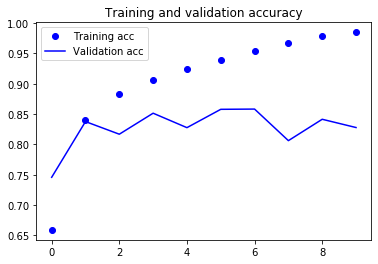

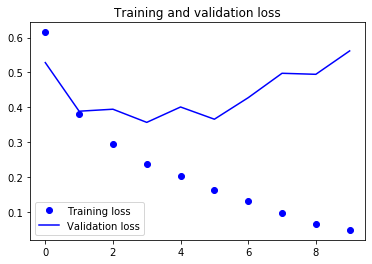

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [9]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 28s 180ms/step - loss: 0.5259 - acc: 0.7541 - val_loss: 0.4033 - val_acc: 0.8344
Epoch 2/10
157/157 [==============================] - 27s 174ms/step - loss: 0.2961 - acc: 0.8862 - val_loss: 0.5691 - val_acc: 0.8252
Epoch 3/10
157/157 [==============================] - 27s 172ms/step - loss: 0.2400 - acc: 0.9104 - val_loss: 0.2861 - val_acc: 0.8806
Epoch 4/10
157/157 [==============================] - 27s 171ms/step - loss: 0.2026 - acc: 0.9272 - val_loss: 0.3415 - val_acc: 0.8720
Epoch 5/10
157/157 [==============================] - 27s 170ms/step - loss: 0.1788 - acc: 0.9370 - val_loss: 0.3331 - val_acc: 0.8740
Epoch 6/10
157/157 [==============================] - 28s 180ms/step - loss: 0.1610 - acc: 0.9416 - val_loss: 0.3260 - val_acc: 0.8912
Epoch 7/10
157/157 [==============================] - 28s 178ms/step - loss: 0.1452 - acc: 0.9493 - val_loss: 0.3559 - val_acc: 0.8800
Epoch 8/10
157/157 [==============================] - 2

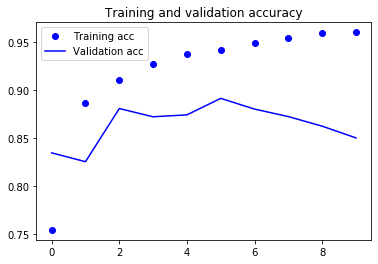

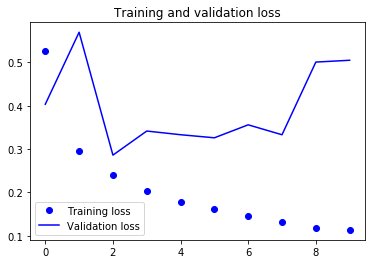

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Übung:
* Um beim Definieren und Trainieren eines LSTMs ein bisschen muscle memory zu entwickeln, schauen wir uns wieder den reuters-Datensatz an. Vielleicht können wir unser gestriges Ergebniss mit LSTMs schlagen?